## Creating model
The purpose of this notebook is to:
- obtain the data from AWS
- create features 
- create model to predict if use will/wont enjoy a beer type 
- train/test and evaluate the model 
- create new features to improve model 
*** 

### Import libaries:
Import libraires needed for this notebook

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import numpy as np

import psycopg2 as pg
import pandas.io.sql as pd_sql

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, fbeta_score
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


Populating the interactive namespace from numpy and matplotlib


***
### Connecting to AWS / Getting Data
A database with tables of the wanted data was created on a previous notebook and stored on AWS. Now need to connect to AWS and that database.

Once on AWS, going to pull the data tables wanted into dataframes.

In [3]:
# Postgres info to connect

connection_args = {
    'host': '52.52.34.207',  # You will need to put the PUBLIC IP address of your AWS instance here (might have changed might have no)
    'user': 'ubuntu',        # your username on AWS is 'ubuntu'
    'dbname': 'beerdata',    # DB that we are connecting to
    'port': 5432             # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [4]:
cursor = connection.cursor()

In [5]:
query = "SELECT * FROM beer;"
beer_reviews_df = pd_sql.read_sql(query, connection)

***
### Creating Features: 

We will create a dataframe with a user-types aggregated version of the complete beer_reviews data. The features we are interested in creating are: 
       
       
User features to make:
- total number of reviews the user has done: user_total_review_count  
- number of reviews for each type done by the user: user_type_review_count
- ratio of reviews of type compared to total reviews done by the user: user_review_type_ratio 
- number of differnet types of beers user has reviewed: user_review_number_of_types  
- average overall rating for each unique beer type: user_avg_overall_rating_of_type
- average aroma rating for each beer type: user_avg_aroma_rating_of_type
- average apperance rating for each beer type: user_avg_apperance_rating_of_type
- average palate rating for each beer type: user_avg_palate_rating_of_type
- average taste rating for each beer type: user_avg_taste_rating_of_type

Beer type features to make:
   - total number of reviews for each beer type: type_total_review_count
   - average overall rating for each type: type_avg_rating 
   

In [6]:
beer_reviews_df.head()

brewery_id             brewery_name   review_time  review_overall  \
0     10325.0          Vecchio Birraio  1.234818e+09             1.5   
1     10325.0          Vecchio Birraio  1.235915e+09             3.0   
2     10325.0          Vecchio Birraio  1.235917e+09             3.0   
3     10325.0          Vecchio Birraio  1.234725e+09             3.0   
4      1075.0  Caldera Brewing Company  1.293735e+09             4.0   

   review_aroma  review_appearance review_profilename  \
0           2.0                2.5            stcules   
1           2.5                3.0            stcules   
2           2.5                3.0            stcules   
3           3.0                3.5            stcules   
4           4.5                4.0     johnmichaelsen   

                       beer_style  review_palate  review_taste  \
0                      Hefeweizen            1.5           1.5   
1              English Strong Ale            3.0           3.0   
2          Foreign / Export Stout            3.0           3.0   
3                 German Pilsener            2.5           3.0   
4  American Double / Imperial IPA            4.0           4.5   

                beer_name  beer_beerid   beer_type  
0            Sausa Weizen      47986.0  Wheat Beer  
1                Red Moon      48213.0  Strong Ale  
2  Black Horse Black Beer      48215.0       Stout  
3              Sausa Pils      47969.0     Pilsner  
4           Cauldron DIPA      64883.0         IPA

In [7]:
df_user_features = (beer_reviews_df.groupby(['review_profilename'],as_index=False) 
                                          .agg({'review_time':'count', 'beer_type': 'nunique',
                                               'review_overall': 'mean'}) 
                                          .rename(columns={'review_time':'user_total_reviews', 
                                                           'beer_type': 'user_review_number_of_types',
                                                           'review_profilename' : 'user',
                                                          'review_overall':'user_overall_avg_rating'}))
df_user_features.head()

user  user_total_reviews  user_review_number_of_types  \
0     0110x011                 139                           18   
1     01Ryan10                   1                            1   
2     02maxima                   4                            4   
3   03SVTCobra                   3                            3   
4  04101Brewer                   3                            2   

   user_overall_avg_rating  
0                 4.241007  
1                 5.000000  
2                 4.000000  
3                 3.000000  
4                 4.166667

In [8]:
df_user_type_features = (beer_reviews_df.groupby(['review_profilename','beer_type'],as_index=False) 
                                          .agg({'review_time':'count', 'review_overall': 'mean', 
                                               'review_aroma': 'mean', 'review_appearance':'mean', 
                                                'review_palate':'mean', 'review_taste':'mean'}) 
                                          .rename(columns={'review_time':'user_type_review_count', 
                                                           'review_overall': 'user_avg_overall_rating_of_type',
                                                          'review_profilename': 'user', 
                                                           'review_aroma': 'user_avg_aroma_rating_of_type',
                                                          'review_appearance': 'user_avg_appearance_rating_of_type',
                                                          'review_palate':'user_avg_palate_rating_of_type',
                                                          'review_taste':'user_avg_taste_rating_of_type'}))
df_user_type_features.head()

user                beer_type  user_type_review_count  \
0  0110x011       American Black Ale                       1   
1  0110x011  American Pale Ale (APA)                       4   
2  0110x011            Belgian Style                       4   
3  0110x011                     Bock                       1   
4  0110x011                Brown Ale                       1   

   user_avg_overall_rating_of_type  user_avg_aroma_rating_of_type  \
0                            5.000                          5.000   
1                            4.375                          3.375   
2                            4.000                          4.125   
3                            4.000                          5.000   
4                            4.500                          3.000   

   user_avg_appearance_rating_of_type  user_avg_palate_rating_of_type  \
0                               4.000                           4.000   
1                               3.625                           3.375   
2                               3.625                           3.750   
3                               4.000                           4.000   
4                               3.000                           3.000   

   user_avg_taste_rating_of_type  
0                          5.000  
1                          3.750  
2                          4.125  
3                          5.000  
4                          4.000

In [9]:
df_user_types = pd.merge(df_user_features, df_user_type_features, on='user', how='outer')

In [10]:
df_user_types.head()

user  user_total_reviews  user_review_number_of_types  \
0  0110x011                 139                           18   
1  0110x011                 139                           18   
2  0110x011                 139                           18   
3  0110x011                 139                           18   
4  0110x011                 139                           18   

   user_overall_avg_rating                beer_type  user_type_review_count  \
0                 4.241007       American Black Ale                       1   
1                 4.241007  American Pale Ale (APA)                       4   
2                 4.241007            Belgian Style                       4   
3                 4.241007                     Bock                       1   
4                 4.241007                Brown Ale                       1   

   user_avg_overall_rating_of_type  user_avg_aroma_rating_of_type  \
0                            5.000                          5.000   
1                            4.375                          3.375   
2                            4.000                          4.125   
3                            4.000                          5.000   
4                            4.500                          3.000   

   user_avg_appearance_rating_of_type  user_avg_palate_rating_of_type  \
0                               4.000                           4.000   
1                               3.625                           3.375   
2                               3.625                           3.750   
3                               4.000                           4.000   
4                               3.000                           3.000   

   user_avg_taste_rating_of_type  
0                          5.000  
1                          3.750  
2                          4.125  
3                          5.000  
4                          4.000

In [11]:
df_user_types['user_review_type_ratio'] = df_user_types['user_type_review_count']/df_user_types['user_total_reviews']

In [12]:
df_user_types.describe()

user_total_reviews  user_review_number_of_types  \
count       233247.000000                233247.000000   
mean           198.245204                    18.020841   
std            384.153534                    11.236628   
min              1.000000                     1.000000   
25%             13.000000                     8.000000   
50%             56.000000                    18.000000   
75%            205.000000                    27.000000   
max           5817.000000                    42.000000   

       user_overall_avg_rating  user_type_review_count  \
count            233247.000000           233247.000000   
mean                  3.861111                6.800799   
std                   0.364034               17.810445   
min                   1.000000                1.000000   
25%                   3.697183                1.000000   
50%                   3.875000                2.000000   
75%                   4.024862                5.000000   
max                   5.000000              818.000000   

       user_avg_overall_rating_of_type  user_avg_aroma_rating_of_type  \
count                    233247.000000                  233247.000000   
mean                          3.818772                       3.711842   
std                           0.673645                       0.658682   
min                           1.000000                       1.000000   
25%                           3.500000                       3.500000   
50%                           4.000000                       3.833333   
75%                           4.181818                       4.000000   
max                           5.000000                       5.000000   

       user_avg_appearance_rating_of_type  user_avg_palate_rating_of_type  \
count                       233247.000000                   233247.000000   
mean                             3.830038                        3.724833   
std                              0.566361                        0.629589   
min                              1.000000                        1.000000   
25%                              3.500000                        3.500000   
50%                              4.000000                        3.833333   
75%                              4.100000                        4.000000   
max                              5.000000                        5.000000   

       user_avg_taste_rating_of_type  user_review_type_ratio  
count                  233247.000000           233247.000000  
mean                        3.802613                0.143140  
std                         0.699223                0.229732  
min                         1.000000                0.000215  
25%                         3.500000                0.020690  
50%                         4.000000                0.054054  
75%                         4.250000                0.142857  
max                         5.000000                1.000000

In [13]:
df_type_features = (beer_reviews_df.groupby(['beer_type'],as_index=False) 
                                          .agg({'review_time':'count', 'review_overall': 'mean'}) 
                                          .rename(columns={'review_time':'type_total_review_count', 
                                                          'review_overall':'type_avg_rating'}))
df_type_features.head()

beer_type  type_total_review_count  type_avg_rating
0               American Black Ale                    11446         3.934475
1             American Malt Liquor                     3925         2.678854
2          American Pale Ale (APA)                    63460         3.852372
3                    Belgian Style                    81773         3.934697
4  Bière de Champagne / Bière Brut                     1046         3.648184

In [14]:
df_X = pd.merge(df_user_types, df_type_features, on=['beer_type'], how='left')

In [15]:
df_X

user  user_total_reviews  user_review_number_of_types  \
0       0110x011                 139                           18   
1       0110x011                 139                           18   
2       0110x011                 139                           18   
3       0110x011                 139                           18   
4       0110x011                 139                           18   
...          ...                 ...                          ...   
233242    zyzygy                   5                            4   
233243    zyzygy                   5                            4   
233244    zyzygy                   5                            4   
233245    zyzygy                   5                            4   
233246  zzajjber                   1                            1   

        user_overall_avg_rating                beer_type  \
0                      4.241007       American Black Ale   
1                      4.241007  American Pale Ale (APA)   
2                      4.241007            Belgian Style   
3                      4.241007                     Bock   
4                      4.241007                Brown Ale   
...                         ...                      ...   
233242                 4.200000            Belgian Style   
233243                 4.200000                Brown Ale   
233244                 4.200000                    Stout   
233245                 4.200000               Strong Ale   
233246                 5.000000               Pale Lager   

        user_type_review_count  user_avg_overall_rating_of_type  \
0                            1                            5.000   
1                            4                            4.375   
2                            4                            4.000   
3                            1                            4.000   
4                            1                            4.500   
...                        ...                              ...   
233242                       1                            4.500   
233243                       2                            4.250   
233244                       1                            4.000   
233245                       1                            4.000   
233246                       1                            5.000   

        user_avg_aroma_rating_of_type  user_avg_appearance_rating_of_type  \
0                               5.000                               4.000   
1                               3.375                               3.625   
2                               4.125                               3.625   
3                               5.000                               4.000   
4                               3.000                               3.000   
...                               ...                                 ...   
233242                          4.500                               5.000   
233243                          3.750                               3.750   
233244                          4.000                               3.500   
233245                          4.500                               4.000   
233246                          5.000                               5.000   

        user_avg_palate_rating_of_type  user_avg_taste_rating_of_type  \
0                                4.000                          5.000   
1                                3.375                          3.750   
2                                3.750                          4.125   
3                                4.000                          5.000   
4                                3.000                          4.000   
...                                ...                            ...   
233242                           4.500                          5.000   
233243                           3.500                          4.000   
233244                           3.500                          4.500   
23

*** 
## Set up classification 

Next we'll set up the classification problem. We want to predict if a user will be interested in a type of beer based on their rating of all the beers they have reviewed. This problem will require us to make individual binary predictions for every unique user-beer combination in the review history, where the target is 1 or 0 for if that beer type will be one of interest.  

A threshold needs to be set of what rating equates to the user 'enjoying a beer'. Then if a users average overall rating for a type of beer is in that treshold, we will say it is true they will enjoy that beer. Since on a 5 point rating scale, let's choose a rating of 4 or higher to be the threshold.

Once we have a classification problem set up we need to check for class imbalance 

In [16]:
df_X['will_enjoy'] = (df_X.user_avg_overall_rating_of_type >= 4).astype(int)

In [17]:
df_X.head()

user  user_total_reviews  user_review_number_of_types  \
0  0110x011                 139                           18   
1  0110x011                 139                           18   
2  0110x011                 139                           18   
3  0110x011                 139                           18   
4  0110x011                 139                           18   

   user_overall_avg_rating                beer_type  user_type_review_count  \
0                 4.241007       American Black Ale                       1   
1                 4.241007  American Pale Ale (APA)                       4   
2                 4.241007            Belgian Style                       4   
3                 4.241007                     Bock                       1   
4                 4.241007                Brown Ale                       1   

   user_avg_overall_rating_of_type  user_avg_aroma_rating_of_type  \
0                            5.000                          5.000   
1                            4.375                          3.375   
2                            4.000                          4.125   
3                            4.000                          5.000   
4                            4.500                          3.000   

   user_avg_appearance_rating_of_type  user_avg_palate_rating_of_type  \
0                               4.000                           4.000   
1                               3.625                           3.375   
2                               3.625                           3.750   
3                               4.000                           4.000   
4                               3.000                           3.000   

   user_avg_taste_rating_of_type  user_review_type_ratio  \
0                          5.000                0.007194   
1                          3.750                0.028777   
2                          4.125                0.028777   
3                          5.000                0.007194   
4                          4.000                0.007194   

   type_total_review_count  type_avg_rating  will_enjoy  
0                    11446         3.934475           1  
1                    63460         3.852372           1  
2                    81773         3.934697           1  
3                    55903         3.845903           1  
4                    54869         3.818103           1

1    0.516757
0    0.483243
Name: will_enjoy, dtype: float64


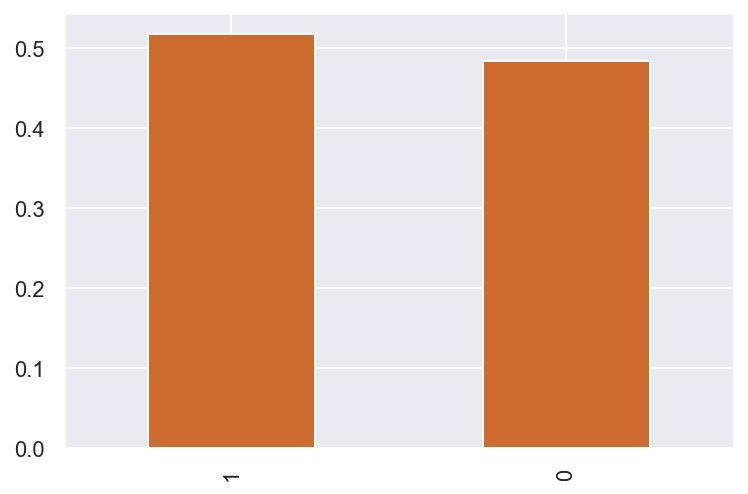

In [18]:
target_pcts = df_X.will_enjoy.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar', color='#ce6c2f')
plt.savefig('class_split.png', dpi=1200, transparent=True)

*** 
### Features and target relation


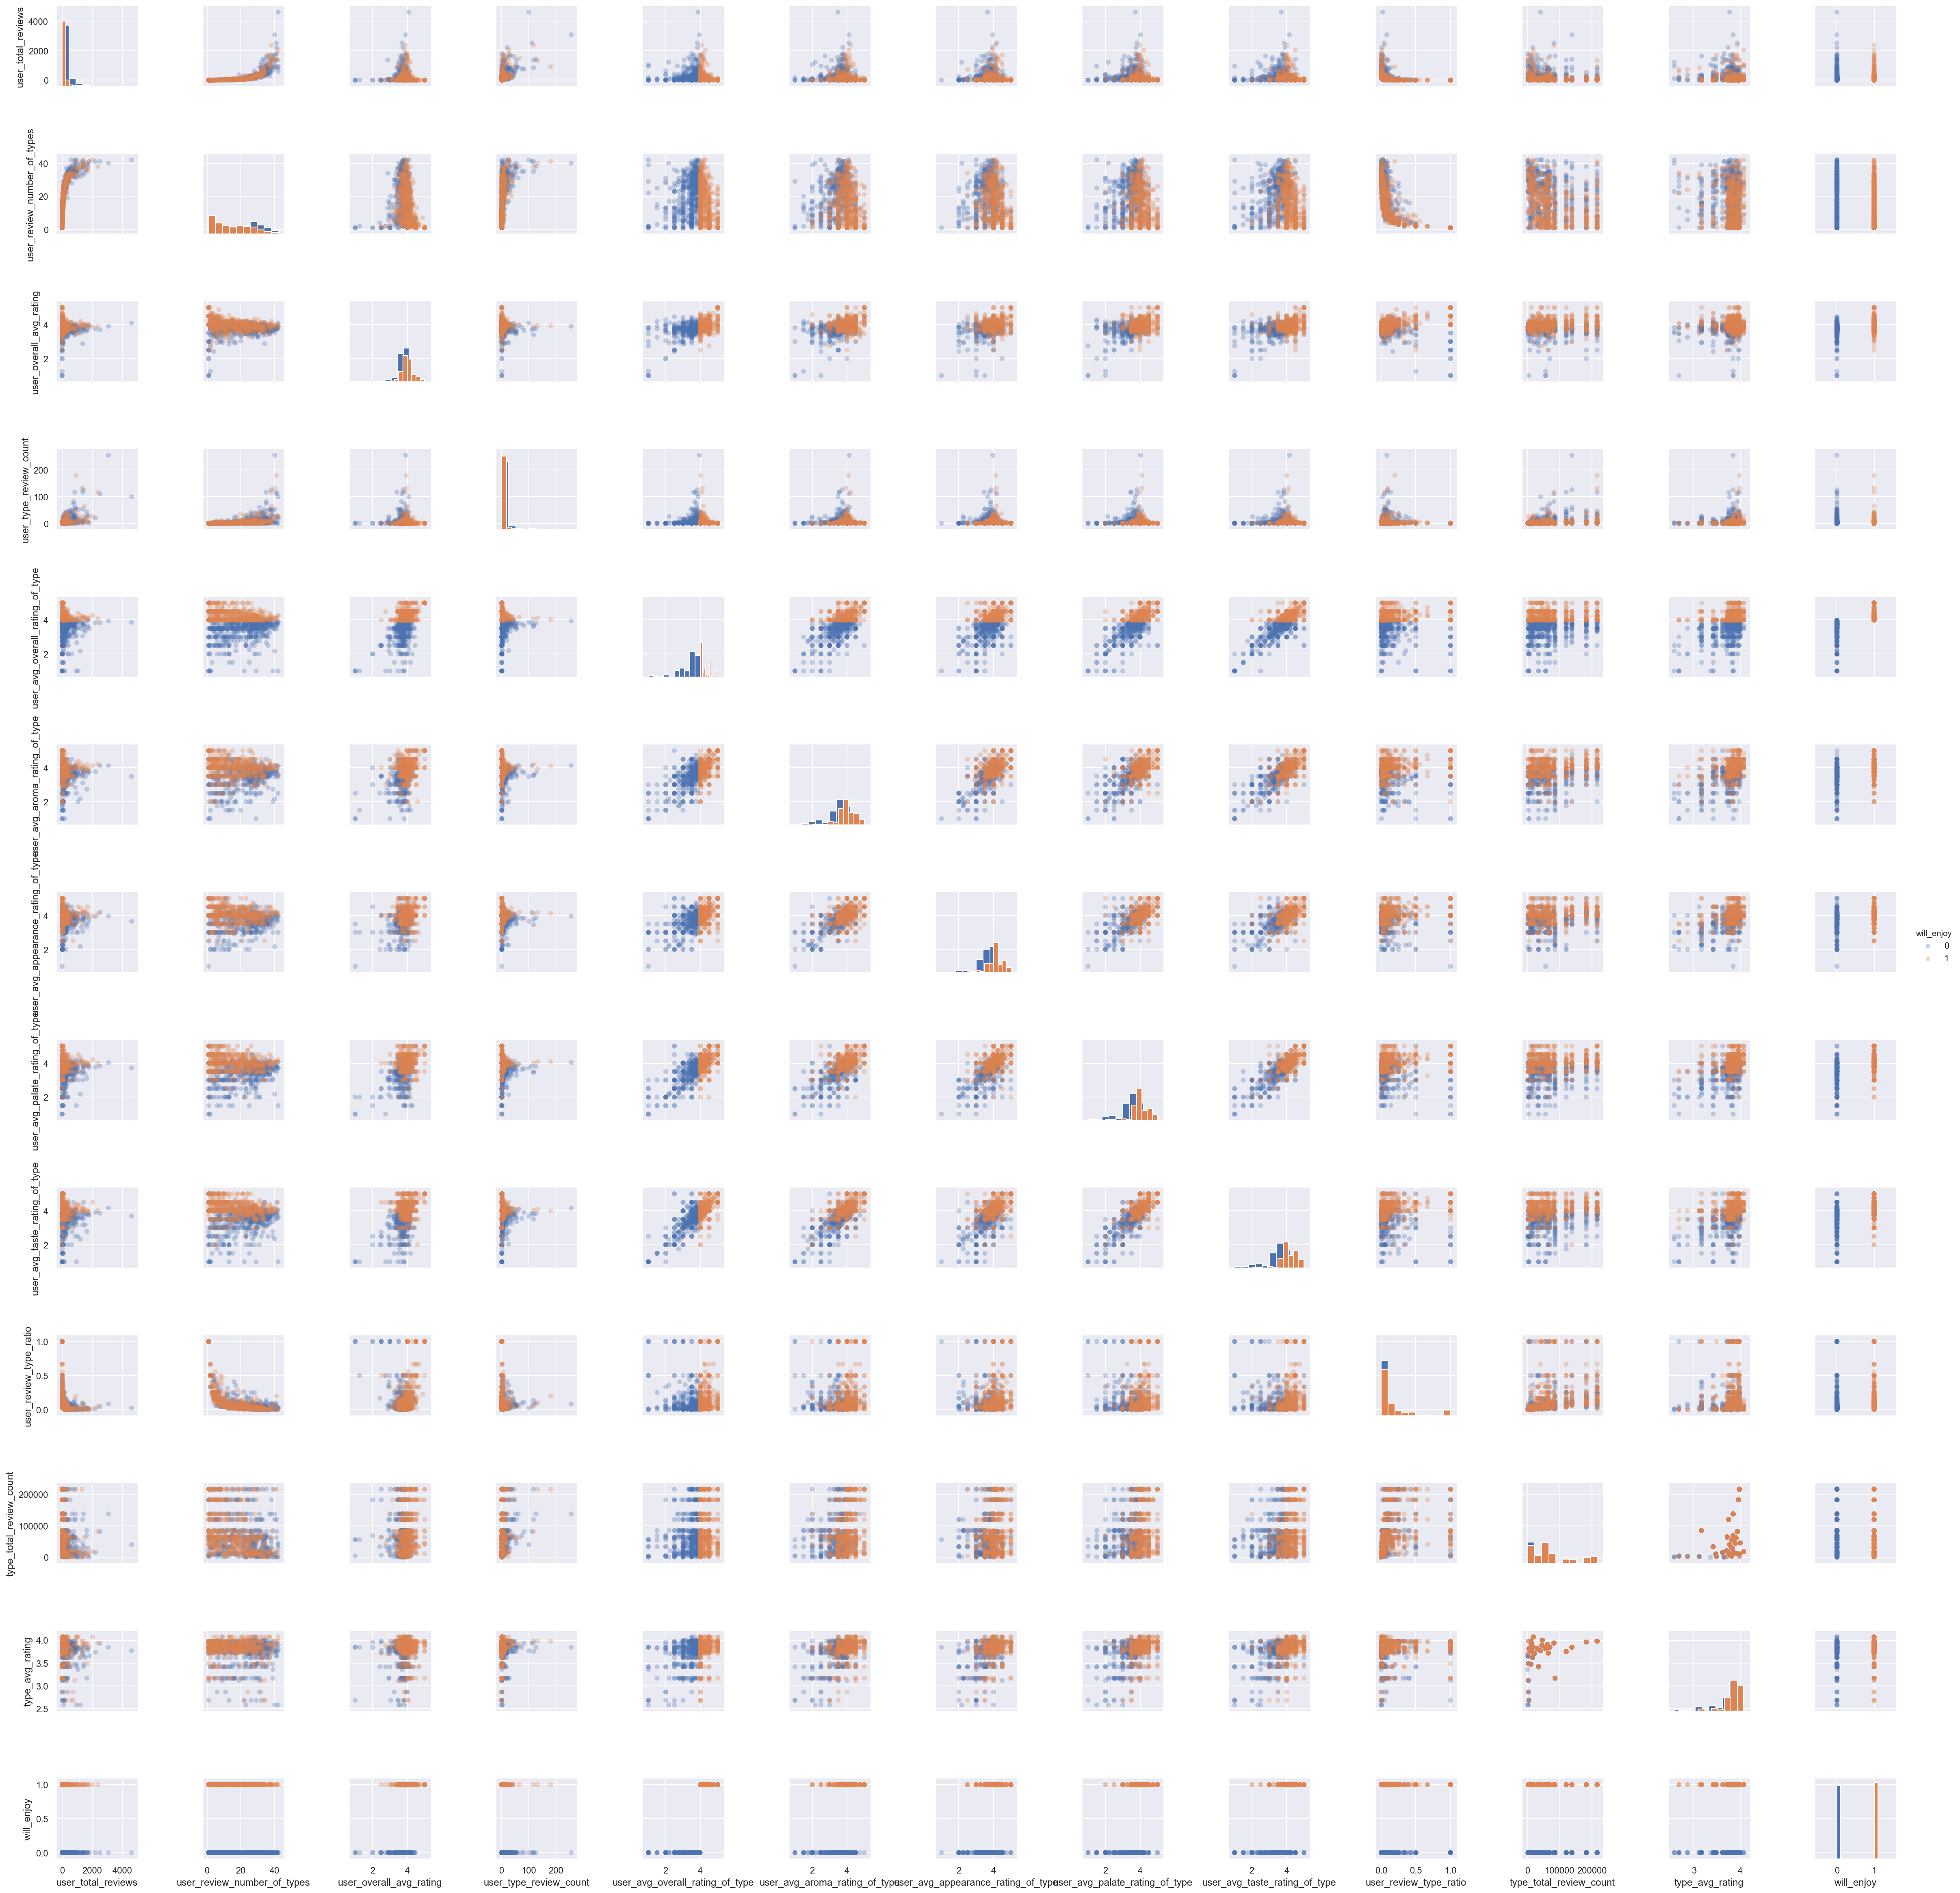

In [19]:
def plot_features(df, sample_size=500):
    
    sample = df.sample(1000, random_state=44)
    sns.pairplot(sample,hue='will_enjoy', plot_kws=dict(alpha=.3, edgecolor='none'), diag_kind='hist')

plot_features(df_X)

*** 
## Validation/ testing

For this problem, we want to be careful about validation/testing. If we were to do a simple train/test split, there could be users users that end up in both the training and test data and will cause a risk of overfitting to the tendencies of specific users. Let's instead manually sample 20% of the users to put into our test set, and use the remaining 80% of users for the training data. 

Since might be doing this several times as we continue to create features, we'll encapsulate the sampling process in a `get_user_split_data` function that mimics the behavior of sklearn's `train_test_split.`

In [20]:
def get_user_split_data(df, test_size=.20, seed=45):

    rs = np.random.RandomState(seed)
    
    total_users = df['user'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_train = df[~df['user'].isin(test_users)]
    df_test = df[df['user'].isin(test_users)] 

    y_train, y_test = df_train['will_enjoy'], df_test['will_enjoy']
    X_train = df_train.drop(['user','beer_type', 'will_enjoy'],axis=1) 
    X_test = df_test.drop(['user', 'beer_type', 'will_enjoy'],axis=1) 
    
    return X_train, X_test, y_train, y_test, df_train, df_test

In [21]:
X_train, X_test, y_train, y_test, df_train, df_test = get_user_split_data(df_X)

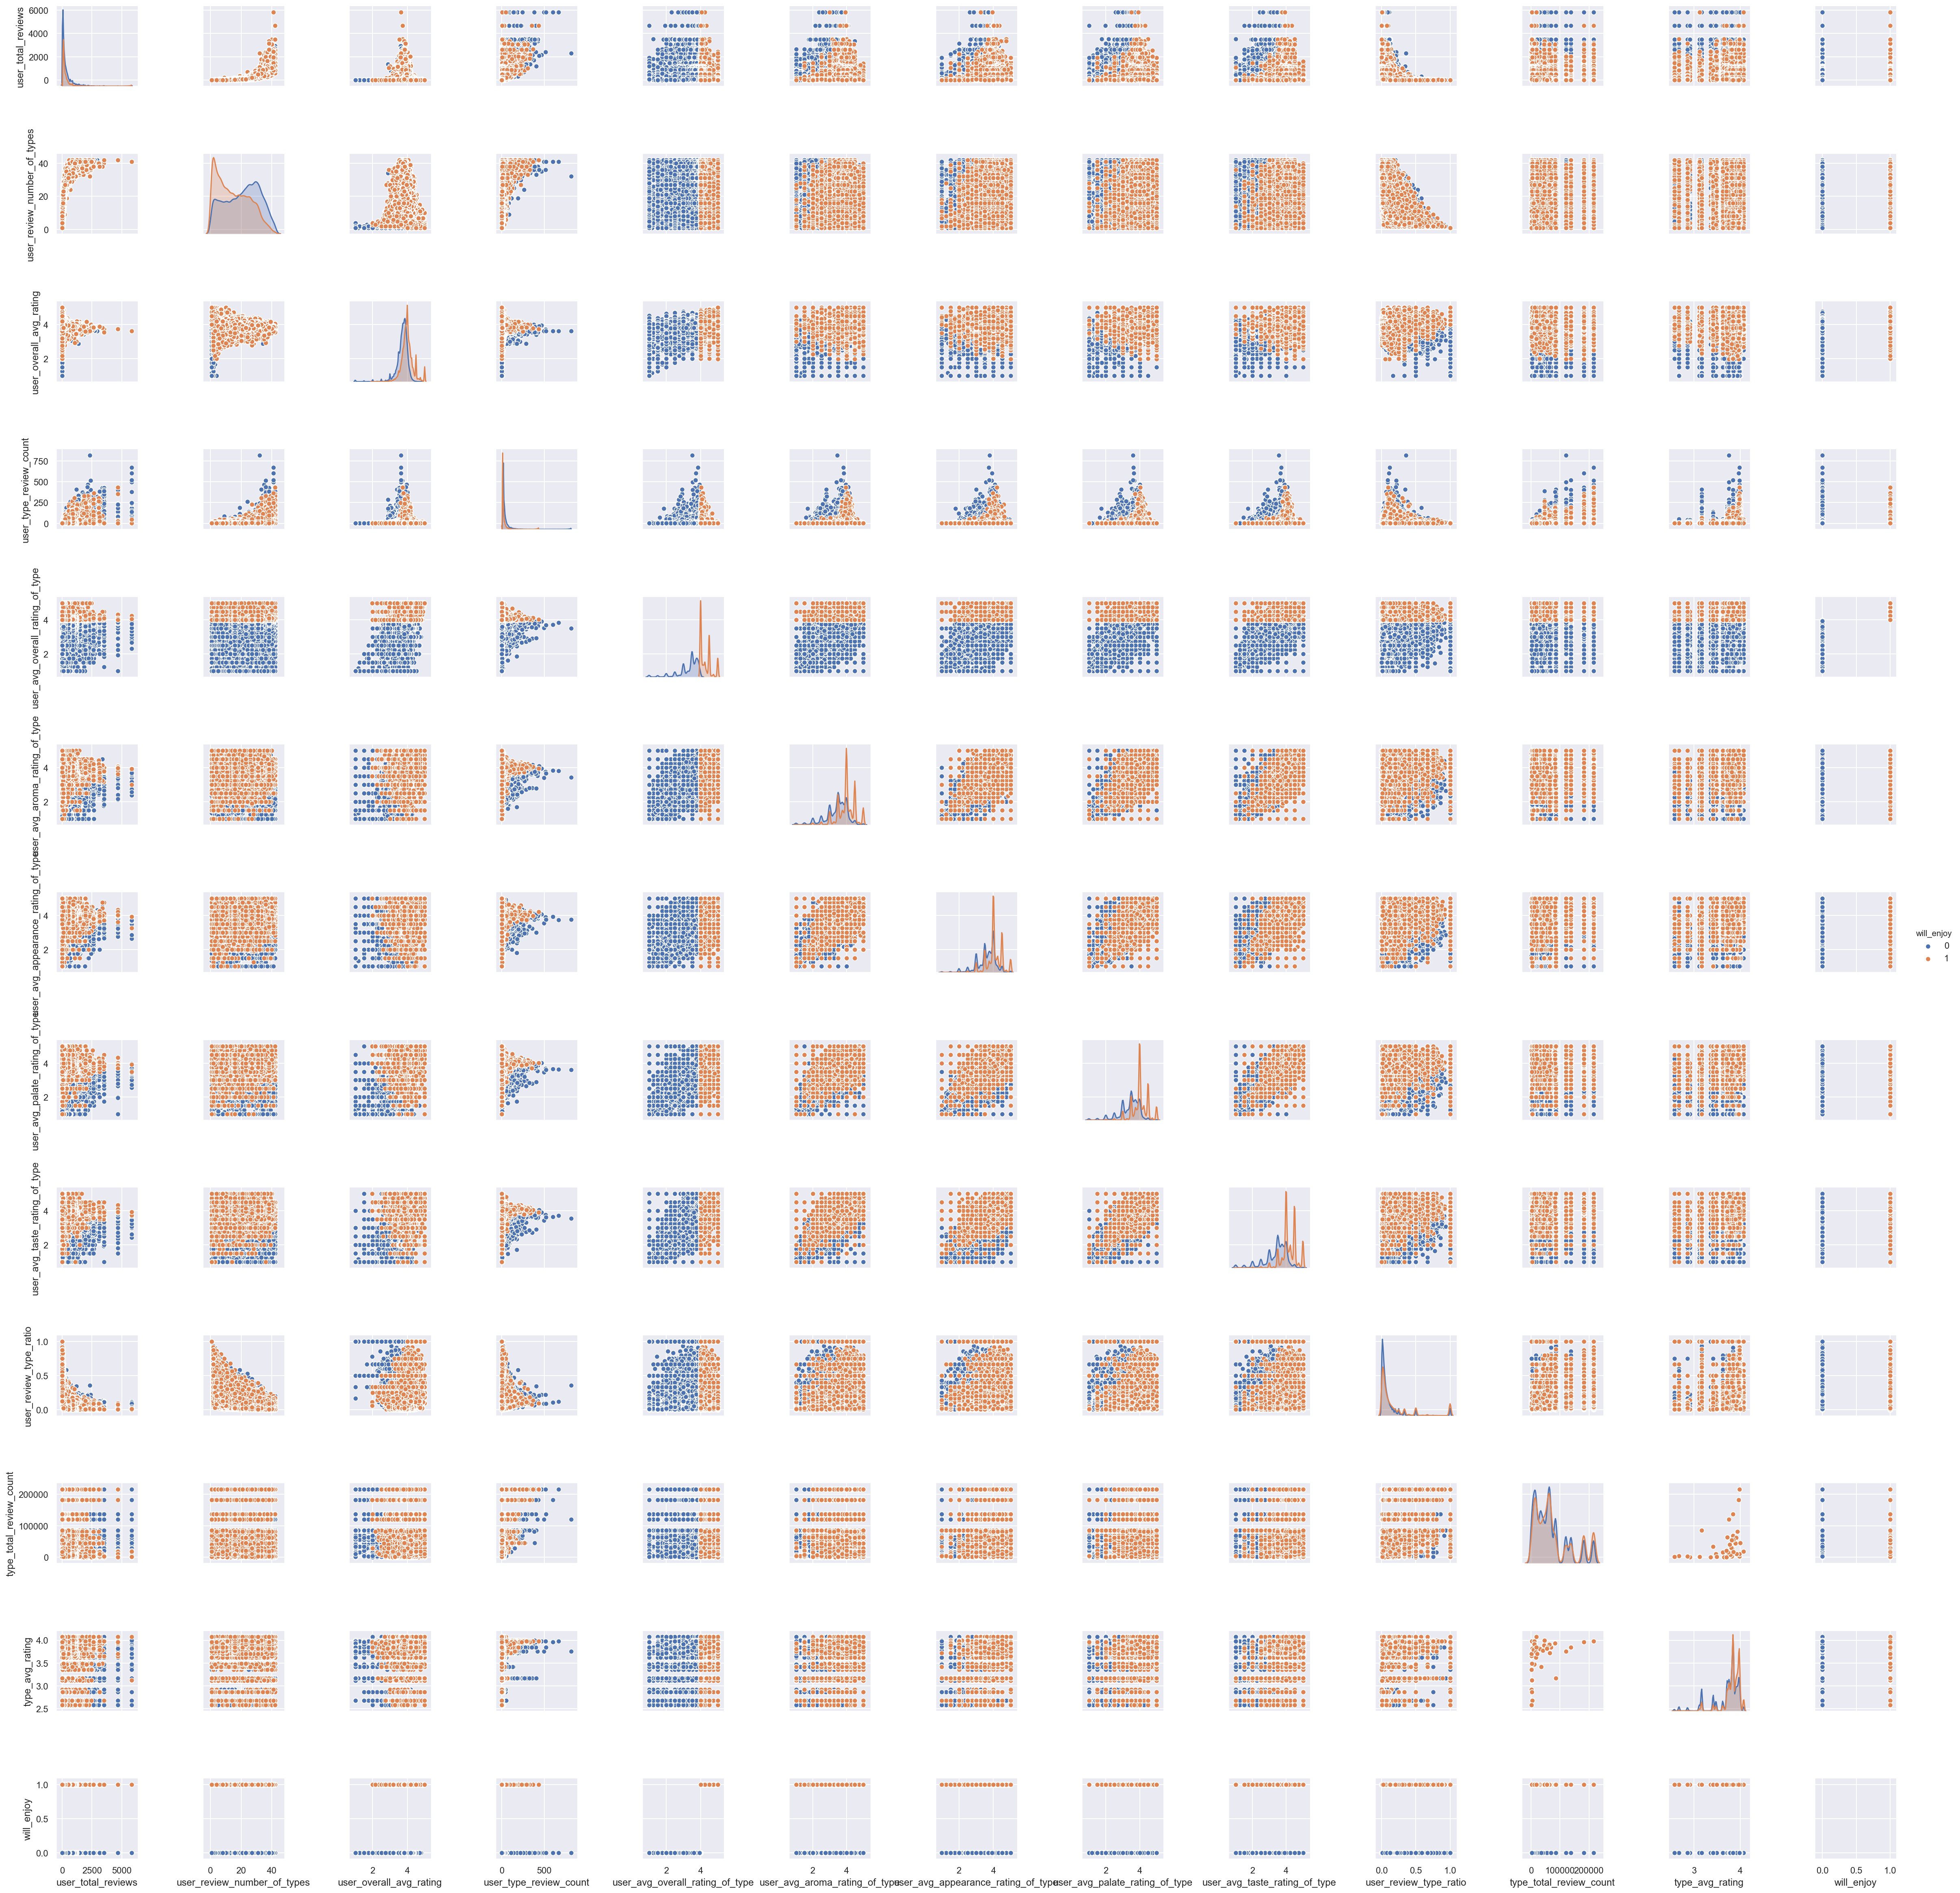

In [22]:
# can look down the diagonal to see what features better seperate our 2 cases
sns.pairplot(df_train, hue='will_enjoy');

*** 
## Training the model

Now we will run split our test/train data sets though muiltipule models to find which gives the best score. The model of which gives the best score is the one we will use. When making the models we will do a grid search to get the best parameters for each model.

I Have placed these steps be in functions that way when doing more features can run the models again with the new data sets.

In [23]:
# make logistic regession model with gridsearchCV for parameters 
def make_lr():
    lr = linear_model.LogisticRegression()
    C = np.logspace(-4, 4, 20)
    hyperparameters = dict(C=C)
    grid_lr = GridSearchCV(lr, hyperparameters, cv=5, verbose=0)
    best_model_lr = grid_lr.fit(X_train, y_train)
    lr_model = linear_model.LogisticRegression(solver= 'liblinear', C= best_model_lr.best_estimator_.get_params()['C'])
    return lr_model

In [24]:
# make KNN model with gridsearchCV for parameters 
def make_knn():
    knn = neighbors.KNeighborsClassifier()
    k_range = list(range(1, 100))
    param_grid_knn = dict(n_neighbors=k_range)
    grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
    best_model_knn = grid_knn.fit(X_train, y_train)
    knn_model = best_model_knn.best_estimator_ 
    return knn_model

In [25]:
# make decision tree model with gridsearchCV for parameters 
def make_dc():
    dc = DecisionTreeClassifier()
    sample_split_range = list(range(2, 50))
    param_grid_dc = dict(min_samples_split=sample_split_range)
    grid_dc = GridSearchCV(dc, param_grid_dc, cv=5, scoring='accuracy')
    best_model_dc = grid_dc.fit(X_train, y_train)
    dc_model = best_model_dc.best_estimator_
    return dc_model

In [26]:
# make random forest model with gridsearchCV for parameters 
def make_rf():
    rf = ensemble.RandomForestClassifier()
    param_grid_rf = { 'n_estimators': [100, 200, 500],'max_depth' : [1,4,5,6,7,8], 'criterion' :['gini', 'entropy']}
    grid_rf = GridSearchCV(rf, param_grid = param_grid_rf, cv = 5, verbose=True, n_jobs=-1)
    best_model_rf = grid_rf.fit(X_train, y_train)
    rf_model = best_model_rf.best_estimator_
    return rf_model

In [55]:
# funtion that will:
    # 1. train/test split the data using the function made earlier 
    # 2. make all the models defined using the dataset 
    # 3. get the scores of the models
    # 4. print the ROC curve comparison of all models 
def make_models(df, filetitle):

    # split the data on the current set we are working with 
    X_train, X_test, y_train, y_test, df_train, df_test = get_user_split_data(df)
    
    # create models using functions made above   
    lr_model = make_lr()
    nb_model = naive_bayes.GaussianNB() #NB doesn't have gridsearch so no function
    knn_model = make_knn()
    dc_model = make_dc()
    rf_model = make_rf()
    

    models = ["lr_model", "nb_model", "knn_model", "dc_model", "rf_model"]
    
    # make a table for the scores of all the models  
    cols = ['model', 'accuracy', 'roc auc', 'f1', 'precision', 'recall']
    df_scores = pd.DataFrame(columns = cols)

    # run through the models and fit on the train data 
    for model_name in models:
        curr_model = eval(model_name)
        curr_model.fit(X_train, y_train)
        y_predict = curr_model.predict(X_test)
        
        # get the scores of all the models 
        df_scores = df_scores.append({'model': model_name, 'accuracy': curr_model.score(X_test, y_test), 
                                      'roc auc': roc_auc_score(y_test, curr_model.predict_proba(X_test)[:,1]),
                                      'f1': metrics.f1_score(y_test, y_predict), 
                                      'precision': precision_score(y_test, y_predict), 
                                      'recall':recall_score(y_test, y_predict)},
                                     ignore_index=True)
    print(df_scores)
    
    # plot the roc curve to compare between the models 
    color_dic = {"lr_model": 'xkcd:dull red', "nb_model": 'xkcd:reddy brown', "knn_model": 'xkcd:orange brown', 
                 "dc_model": 'xkcd:copper', "rf_model": 'xkcd:dusty orange'}

    for model_name in models:
        curr_model = eval(model_name)
        # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y_test, curr_model.predict_proba(X_test)[:,1])
        # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(y_test,curr_model.predict(X_test))
        # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (model_name, auc),c=color_dic[model_name])

    ax = plt.gca()
    ax.grid(zorder=0, color='#edecec')
    ax.set_facecolor(color = '#fff5ec')

    plt.plot([0,1],[0,1],c='xkcd:mushroom',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc="lower right")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for will enjoy');
    plt.savefig(filetitle, dpi=1200, transparent=True)
    
    return lr_model, nb_model, knn_model, dc_model, rf_model

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 25.3min finished


       model  accuracy   roc auc       f1  precision    recall
0   lr_model  0.732658  0.821964  0.74835   0.722872  0.775689
1   nb_model  0.617752  0.780847  0.70915   0.581198  0.909344
2  knn_model  0.771209  0.857801  0.76670   0.802922  0.733605
3   dc_model  1.000000  1.000000  1.00000   1.000000  1.000000
4   rf_model  1.000000  1.000000  1.00000   1.000000  1.000000


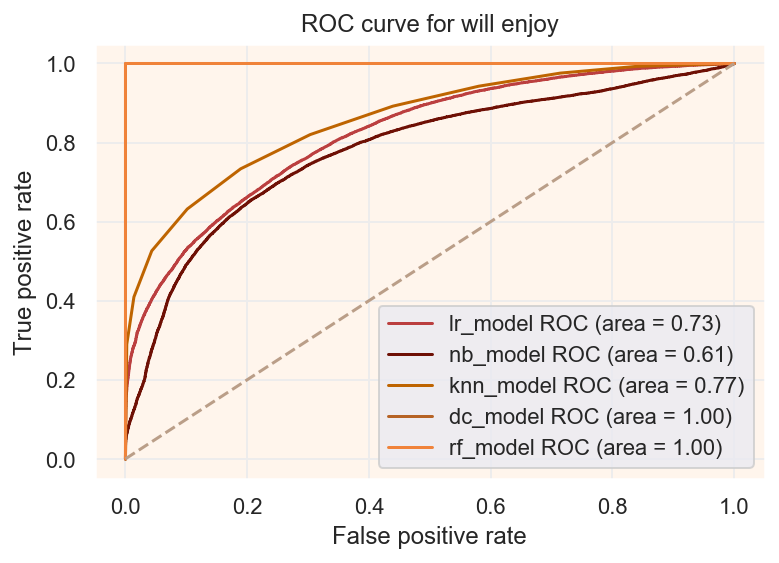

In [28]:
lr_model, nb_model, knn_model, dc_model, rf_model = make_models(df_X, 'roc_curve_firstdf.png')

Choosing to continue with logistic regression for now. Decision trees and random forests give a perfect classifier which could mean there is some data leakage. Even thought KNN is slightly better than logisitc regession, we want to look at feature importance which cannot be done with KNN.

*** 
## Evalute the model
Once what the model to be used is choosen, let's look closer at the modle to evalute it by looking at:
- Confustion Matix
- Precision and Recall
- ROC curve
- Feature Importance 

I have placed all these plots in functions to be easily called again when using new data after conducting further feature importance. 

In [56]:
def make_confusion_matrix(model, title, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    no_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(no_confusion, cmap=plt.cm.Oranges, annot=True, square=True, fmt='d',
           xticklabels=['will enjoy', 'wont enjoy'],
           yticklabels=['will enjoy', 'wont enjoy']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title(title)
    plt.savefig(title + '.png', dpi=1200, transparent=True)

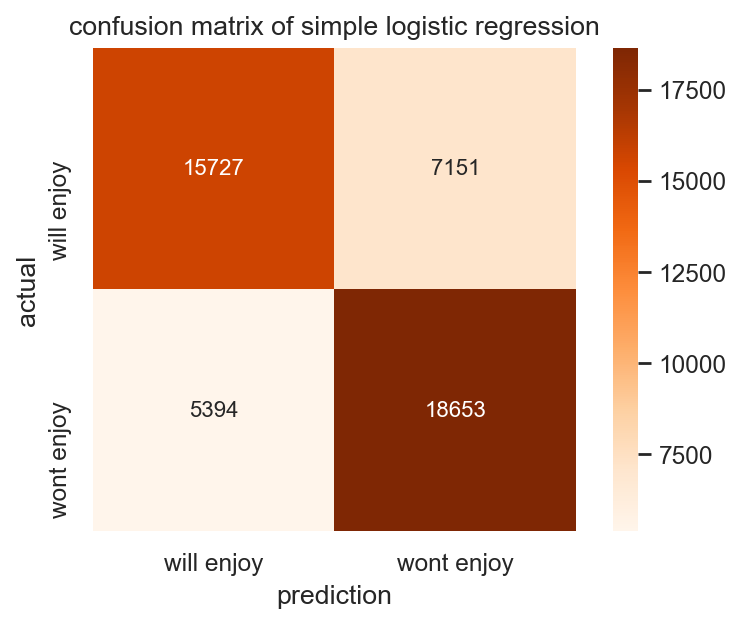

In [30]:
make_confusion_matrix(lr_model, 'Confusion Matrix of Logistic Regression')

In [33]:
# plotting feature importance 
def make_feature_importance(model, title):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center', color='#ce6c2f')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
    
    plot_title = 'Relative Feature Importance for ' + title
    featax.set_xlabel(plot_title)
    featax.grid(zorder=0, color='#edecec')
    plt.tight_layout()   
    plt.plot()
    plt.savefig(plot_title + '.png', dpi=1200, transparent=True)


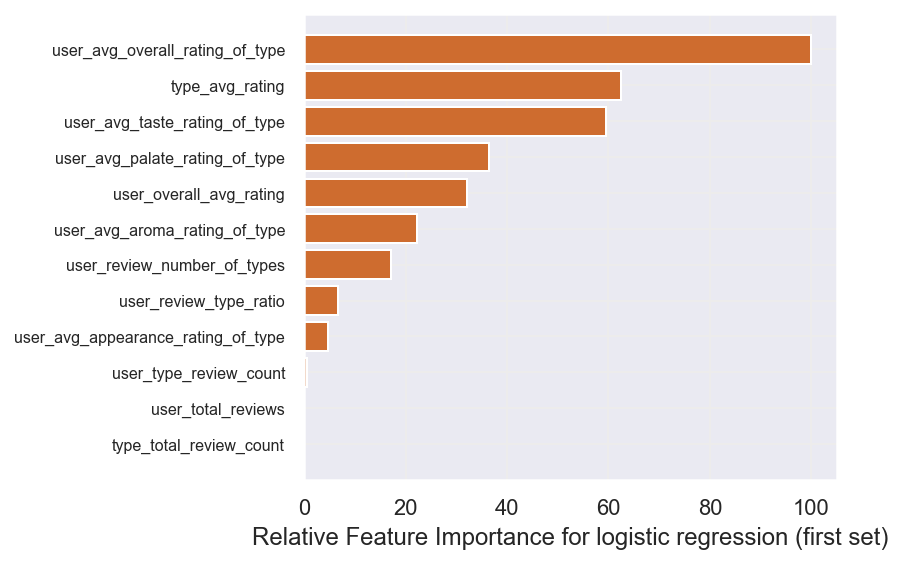

In [34]:
make_feature_importance(lr_model, 'logistic regression (first set)')

look at what has high importance to see what other things we can do with the feature to imporve the model 

In [57]:
# use the probabilities to make a curve showing how recall and thresholds trade off 
def make_precision_recall_curve(model, title):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1] )
    plt.figure(dpi=80)
    plt.plot(threshold_curve, precision_curve[1:],label='precision', color= 'xkcd:reddy brown')
    plt.plot(threshold_curve, recall_curve[1:], label='recall', color='xkcd:copper')
    
    ax = plt.gca()
    ax.grid(zorder=0, color='#edecec')
    
    plt.legend(loc='lower left')
    plt.xlabel('Threshold');
    plot_title = 'Precision and Recall Curves for ' + title
    plt.title(plot_title);
    plt.savefig(plot_title + '.png', dpi=1200, transparent=True)

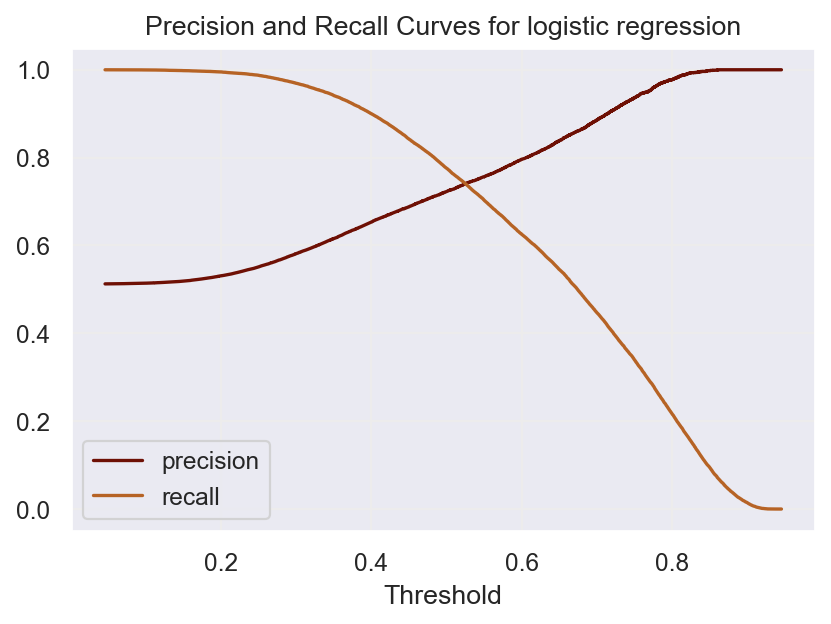

In [39]:
make_precision_recall_curve(lr_model, 'logistic regression')

In [60]:
def make_ROC_curve(model, title):
    # Precision = TP / (TP + FP)
    # Recall = TP/P = True positive rate
    # false positive rate = FP / true negatives = FP / (FP + TN) 

    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot(fpr, tpr,lw=2, color= 'xkcd:reddy brown')
    plt.plot([0,1],[0,1],c='xkcd:mushroom',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    ax = plt.gca()
    ax.grid(zorder=0, color='#edecec')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate') 
    plot_title = 'ROC Curve for Will Enjoy on ' + title
    plt.title(plot_title);
    plt.savefig(plot_title + '.png', dpi=1200, transparent=True)
    print("ROC AUC score = ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

ROC AUC score =  0.8219638321350851


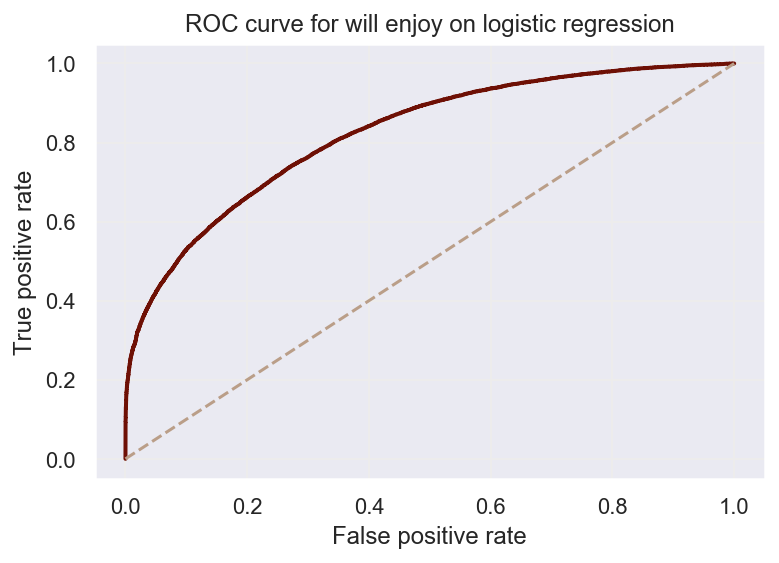

In [43]:
make_ROC_curve(lr_model, 'logistic regression')

***
## Improving the model
The model has given us a good ROC AUC score with the features we started with. Now let's play with some features to see what else can be done to make this even better. 

Once we do more feature engineering, we can run the the new dataset throuh the `make_models` function to get compare all the model with the new data. After that we can evaluate the models and see if we want to do more feature engieering. 

In [44]:
df_X_new = df_X

In [45]:
# drop the features that had 0 importance 
df_X_new = df_X_new.drop(columns = ['type_total_review_count', 'user_total_reviews'])

In [46]:
df_X_new.head()

user  user_review_number_of_types  user_overall_avg_rating  \
0  0110x011                           18                 4.241007   
1  0110x011                           18                 4.241007   
2  0110x011                           18                 4.241007   
3  0110x011                           18                 4.241007   
4  0110x011                           18                 4.241007   

                 beer_type  user_type_review_count  \
0       American Black Ale                       1   
1  American Pale Ale (APA)                       4   
2            Belgian Style                       4   
3                     Bock                       1   
4                Brown Ale                       1   

   user_avg_overall_rating_of_type  user_avg_aroma_rating_of_type  \
0                            5.000                          5.000   
1                            4.375                          3.375   
2                            4.000                          4.125   
3                            4.000                          5.000   
4                            4.500                          3.000   

   user_avg_appearance_rating_of_type  user_avg_palate_rating_of_type  \
0                               4.000                           4.000   
1                               3.625                           3.375   
2                               3.625                           3.750   
3                               4.000                           4.000   
4                               3.000                           3.000   

   user_avg_taste_rating_of_type  user_review_type_ratio  type_avg_rating  \
0                          5.000                0.007194         3.934475   
1                          3.750                0.028777         3.852372   
2                          4.125                0.028777         3.934697   
3                          5.000                0.007194         3.845903   
4                          4.000                0.007194         3.818103   

   will_enjoy  
0           1  
1           1  
2           1  
3           1  
4           1

In [47]:
# avg_user_taste_rating_of_type has hight importance, lets look at the average 
# taste rating for each type as well
df_type_features = (beer_reviews_df.groupby(['beer_type'],as_index=False) 
                                          .agg({'review_taste': 'mean'}) 
                                          .rename(columns={'review_taste':'type_avg_taste_rating'}))
df_type_features.head()

beer_type  type_avg_taste_rating
0               American Black Ale               3.971606
1             American Malt Liquor               2.541146
2          American Pale Ale (APA)               3.721423
3                    Belgian Style               3.947452
4  Bière de Champagne / Bière Brut               3.693117

In [48]:
df_X_new = pd.merge(df_X_new, df_type_features, on=['beer_type'], how='left')

In [49]:
df_X_new.head()

user  user_review_number_of_types  user_overall_avg_rating  \
0  0110x011                           18                 4.241007   
1  0110x011                           18                 4.241007   
2  0110x011                           18                 4.241007   
3  0110x011                           18                 4.241007   
4  0110x011                           18                 4.241007   

                 beer_type  user_type_review_count  \
0       American Black Ale                       1   
1  American Pale Ale (APA)                       4   
2            Belgian Style                       4   
3                     Bock                       1   
4                Brown Ale                       1   

   user_avg_overall_rating_of_type  user_avg_aroma_rating_of_type  \
0                            5.000                          5.000   
1                            4.375                          3.375   
2                            4.000                          4.125   
3                            4.000                          5.000   
4                            4.500                          3.000   

   user_avg_appearance_rating_of_type  user_avg_palate_rating_of_type  \
0                               4.000                           4.000   
1                               3.625                           3.375   
2                               3.625                           3.750   
3                               4.000                           4.000   
4                               3.000                           3.000   

   user_avg_taste_rating_of_type  user_review_type_ratio  type_avg_rating  \
0                          5.000                0.007194         3.934475   
1                          3.750                0.028777         3.852372   
2                          4.125                0.028777         3.934697   
3                          5.000                0.007194         3.845903   
4                          4.000                0.007194         3.818103   

   will_enjoy  type_avg_taste_rating  
0           1               3.971606  
1           1               3.721423  
2           1               3.947452  
3           1               3.874077  
4           1               3.765131

In [50]:
df_X_new['taste_rating_diff'] = df_X_new['user_avg_taste_rating_of_type'] - df_X_new['type_avg_taste_rating']

In [51]:
# check out difference in users average overall rating and the average rating for each certain type 
df_X_new['user_avg_overall_rating_diff'] = df_X_new['user_avg_overall_rating_of_type'] - df_X_new['user_overall_avg_rating']


In [52]:
df_X_new['user_type_overall_rating_diff'] = df_X_new['user_avg_overall_rating_of_type'] - df_X_new['type_avg_rating']

In [53]:
df_X_new.head()

user  user_review_number_of_types  user_overall_avg_rating  \
0  0110x011                           18                 4.241007   
1  0110x011                           18                 4.241007   
2  0110x011                           18                 4.241007   
3  0110x011                           18                 4.241007   
4  0110x011                           18                 4.241007   

                 beer_type  user_type_review_count  \
0       American Black Ale                       1   
1  American Pale Ale (APA)                       4   
2            Belgian Style                       4   
3                     Bock                       1   
4                Brown Ale                       1   

   user_avg_overall_rating_of_type  user_avg_aroma_rating_of_type  \
0                            5.000                          5.000   
1                            4.375                          3.375   
2                            4.000                          4.125   
3                            4.000                          5.000   
4                            4.500                          3.000   

   user_avg_appearance_rating_of_type  user_avg_palate_rating_of_type  \
0                               4.000                           4.000   
1                               3.625                           3.375   
2                               3.625                           3.750   
3                               4.000                           4.000   
4                               3.000                           3.000   

   user_avg_taste_rating_of_type  user_review_type_ratio  type_avg_rating  \
0                          5.000                0.007194         3.934475   
1                          3.750                0.028777         3.852372   
2                          4.125                0.028777         3.934697   
3                          5.000                0.007194         3.845903   
4                          4.000                0.007194         3.818103   

   will_enjoy  type_avg_taste_rating  taste_rating_diff  \
0           1               3.971606           1.028394   
1           1               3.721423           0.028577   
2           1               3.947452           0.177548   
3           1               3.874077           1.125923   
4           1               3.765131           0.234869   

   user_avg_overall_rating_diff  user_type_overall_rating_diff  
0                      0.758993                       1.065525  
1                      0.133993                       0.522628  
2                     -0.241007                       0.065303  
3                     -0.241007                       0.154097  
4                      0.258993                       0.681897

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 19.0min finished


       model  accuracy   roc auc        f1  precision    recall
0   lr_model  0.947107  0.987922  0.949033   0.937406  0.960951
1   nb_model  0.860799  0.954571  0.873037   0.819605  0.933921
2  knn_model  0.952946  0.991996  0.953256   0.970891  0.936250
3   dc_model  1.000000  1.000000  1.000000   1.000000  1.000000
4   rf_model  1.000000  1.000000  1.000000   1.000000  1.000000


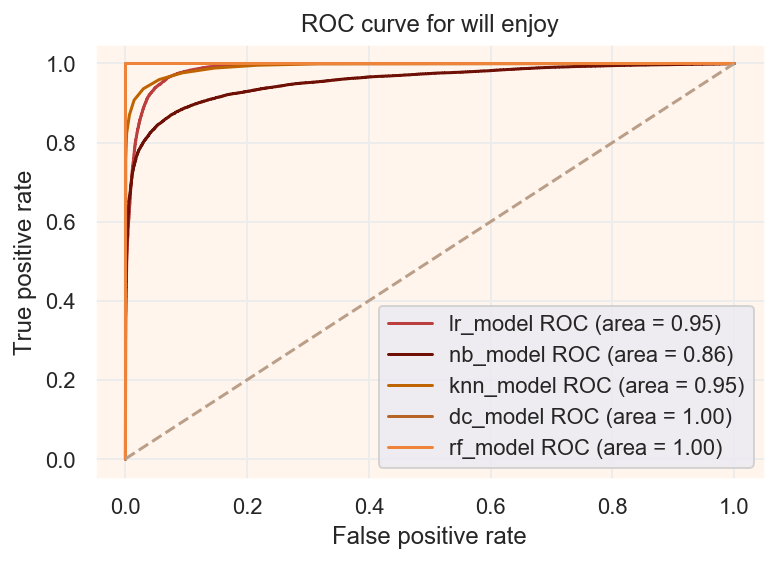

In [61]:
lr_model, nb_model, knn_model, dc_model, rf_model = make_models(df_X_new, 'roc_curve_seconddf.png')

Here logistics regression and KNN are very similar, but would like to use logisitc regression to see feature importance. I am also concered about data leakage with random forests and descision trees as they have a perfect score. Niave bayes 

In [64]:
X_train, X_test, y_train, y_test, df_train, df_test = get_user_split_data(df_X_new)

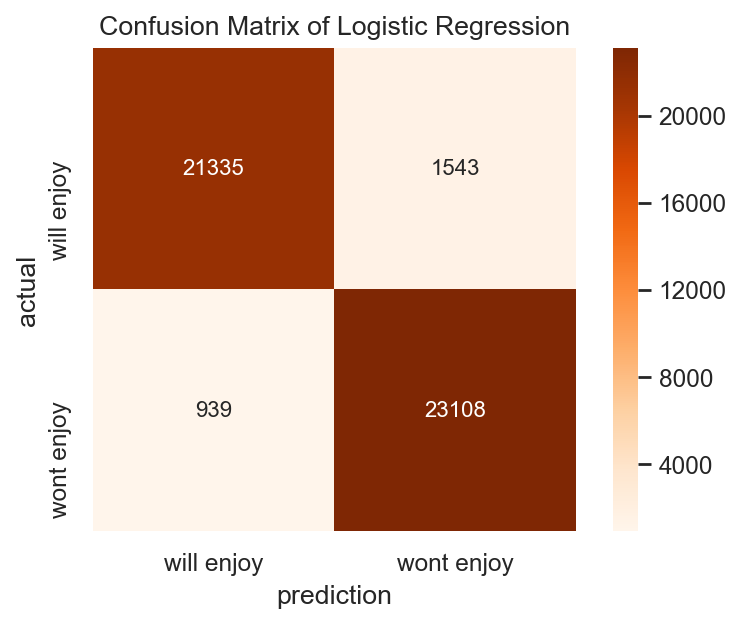

In [65]:
make_confusion_matrix(lr_model, 'Confusion Matrix of Logistic Regression')

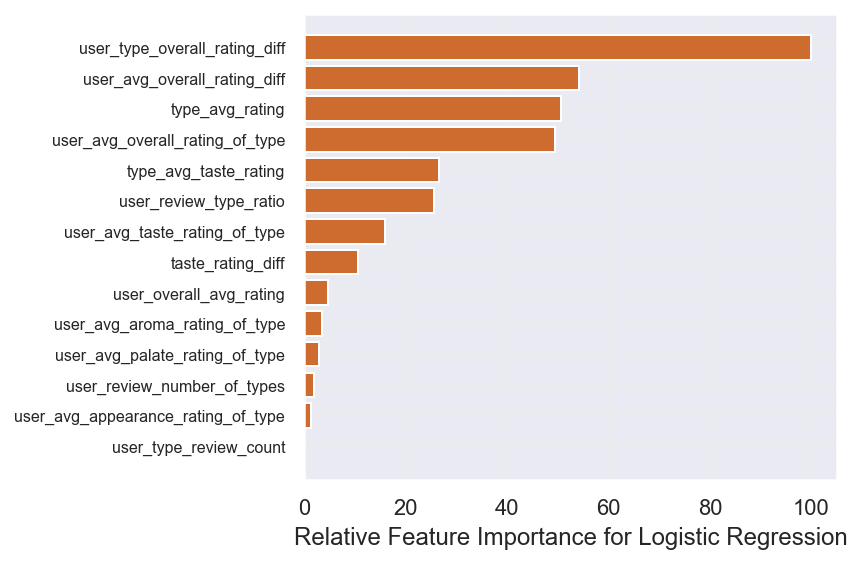

In [66]:
make_feature_importance(lr_model, 'Logistic Regression')

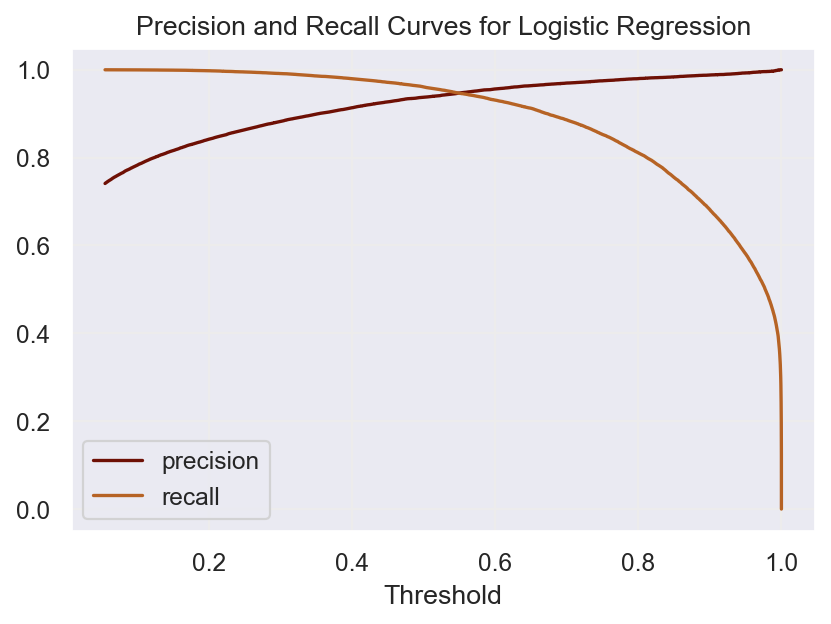

In [67]:
make_precision_recall_curve(lr_model, 'Logistic Regression')

ROC AUC score =  0.9879217340325744


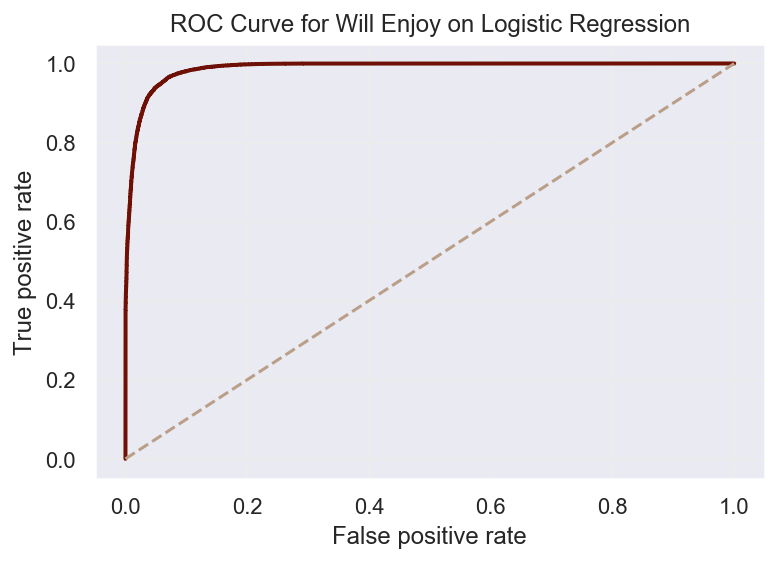

In [68]:
make_ROC_curve(lr_model, 'Logistic Regression')

Understanding features: 

- ratio of reviews of type compared to total reviews done by the user: user_review_type_ratio 
- number of differnet types of beers user has reviewed: user_review_number_of_types  
- average overall rating for each unique beer type: user_avg_overall_rating_of_type
- average aroma rating for each beer type: user_avg_aroma_rating_of_type
- average apperance rating for each beer type: user_avg_apperance_rating_of_type
- average palate rating for each beer type: user_avg_palate_rating_of_type
- average taste rating for each beer type: user_avg_taste_rating_of_type
- differance bewteen the users average overall rating and the users average overall rating for a type: user_avg_overall_rating_diff
- differnece between the users average overall rating of a beer type and that types overall average rating: user_type_overall_rating_diff
- average overall rating for each type: type_avg_rating 
- average taste rating for each type: type_avg_taste_rating
- difference between the users average taste rating of a beer type and that types taste average rating: taste_rating_diff

would ratio of total number of reviews of types compared to total reviews be helpful?